# DataScience: Build a Supervised Autoencoder.

**Name: Tyler Lott**


In this assignment we implemented both a unsupervised and supervised autoencoder. They were both implemented using pytorch. The dataset being used was the raw MNIST dataset. 

**We will build and train a supervised autoencoder look like the following.** You can add other layers properly to alleviate overfitting.


![Network Structure](https://github.com/wangshusen/CS583A-2019Spring/blob/master/homework/HM5/supervised_ae.png?raw=true "NetworkStructure")



## 1. Data preparation

### 1.1. Load data


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, random_split
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR
# from torchsummary import summary
import numpy as np

device = torch.device("cuda")

Hyper-parameters

In [2]:
args={}
batch_size = 32
test_batch_size = 1000
epochs = 5  # You need to tune this hyper-parameter
learning_rate = 0.01 #Learning rate is how fast it will decend. 

Randomly partition the 60K training samples to 2 sets:
* a training set containing 50K samples;
* a validation set containing 10K samples.

In [3]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=img_transform)
train_dataset, val_dataset = random_split(train_dataset, [50000,10000])
train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=test_batch_size, 
                        shuffle=False)

test_dataset = datasets.MNIST('./data', train=False, download=True, transform=img_transform)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size,
                             shuffle=True, num_workers=2)

## 2. Build an unsupervised  autoencoder and tune its hyper-parameters

1. Build a dense autoencoder model
2. Use the validation data to tune the hyper-parameters (e.g., network structure, and optimization algorithm)
    * Do NOT use test data for hyper-parameter tuning!!!
    
3. Try to achieve a validation loss as low as possible.
4. Evaluate the model on the test set.
5. Visualize the low-dim features.

### 2.1. Build the model

In [4]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), 
            nn.Linear(64, 32), 
            nn.ReLU(True), 
            nn.Linear(32, 2))
        
        self.decoder = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(True),
            nn.Linear(32, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), 
            nn.Linear(128, 28 * 28), 
            nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

ae = autoencoder().cuda()
# summary(ae, input_size=(28*28,))

### 2.2. Train the model and tune the hyper-parameters

In [5]:
ae_criterion = nn.MSELoss()
ae_optimizer = torch.optim.Adam(
    ae.parameters(), lr=learning_rate, weight_decay=1e-5)

In [6]:
train_loss  = []
val_loss = []
for epoch in range(epochs):
    ae.train()
    batch_loss  = []
    for data in train_loader:
        img, _ = data
        img = img.view(img.size(0), -1)
        img = Variable(img).cuda()
        # ===================forward=====================
        output = ae(img)
        loss = ae_criterion(output, img)
        # ===================backward====================
        ae_optimizer.zero_grad()
        loss.backward()
        ae_optimizer.step()
        # ===================log========================
        batch_loss.append(loss.item())
    train_loss.append(np.mean(batch_loss))
    
    
    ae.eval()
    batch_loss  = []
    with torch.no_grad():
      for img, y in val_loader:
          img = img.view(img.size(0), -1)
          img, y = img.cuda(), y.cuda()
          output = ae(img)
          loss = ae_criterion(output, img)
          batch_loss.append(loss.item())
    val_loss.append(np.mean(batch_loss))
    print('epoch [{}/{}], train loss:{:.4f}, val loss:{:.4f}'
          .format(epoch + 1, epochs, train_loss[-1], val_loss[-1]))

epoch [1/5], train loss:0.2044, val loss:0.1864
epoch [2/5], train loss:0.1875, val loss:0.1854
epoch [3/5], train loss:0.1863, val loss:0.1915
epoch [4/5], train loss:0.1826, val loss:0.1851
epoch [5/5], train loss:0.1865, val loss:0.1825


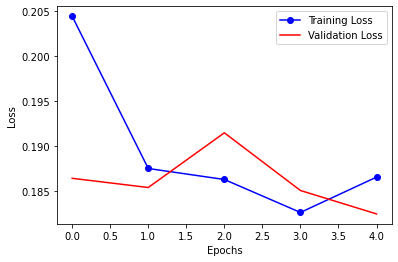

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

epochs_list = range(len(train_loss))
plt.plot(epochs_list, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs_list, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 2.3. Evaluate the model on the test set

Do NOT used the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [8]:
ae.eval()
batch_loss = []
with torch.no_grad():
    for img, y in test_loader:
        img = img.view(img.size(0), -1)
        img, y = img.cuda(), y.cuda()
        output = ae(img)
        loss = ae_criterion(output, img)
        batch_loss.append(loss.item())
    print(f"Test loss:{np.mean(batch_loss)}")

Test loss:0.1814357593655586


### 2.4. Visualize the low-dimensional features

In [9]:
# visualize the features
# your code here

e.eval()
code_vector_list = None
label_list = []
for i, (data, labels) in enumerate(test_loader):
    data = Variable(data).cuda()
    code_vector = ae.encoder(data.view(-1, 28*28))

    if i == 0:
        code_vector_list = code_vector
        label_list = labels
    else:
        code_vector_list = torch.cat((code_vector_list, code_vector), 0)
        label_list = torch.cat((label_list, labels), 0)

code_vector_list = code_vector_list.data.cpu().numpy()[:1000]
label_list = label_list.cpu().numpy()[:1000]

No handles with labels found to put in legend.


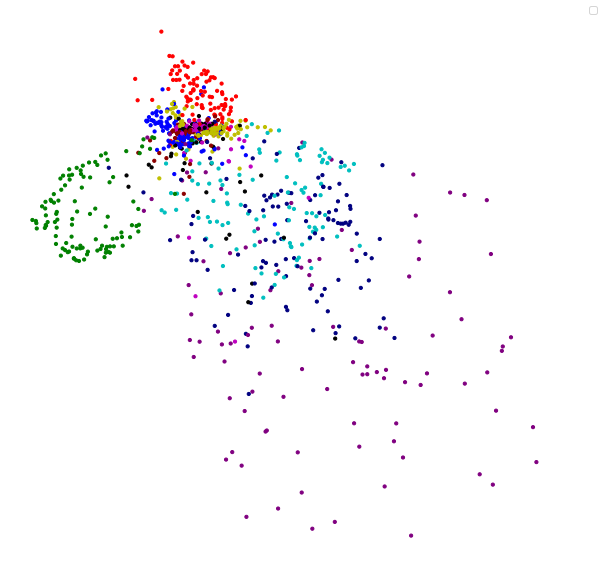

In [10]:
colors = np.array(['r', 'g', 'b', 'm', 'c', 'k', 'y', 'purple', 'darkred', 'navy'])
colors_test = colors[label_list]

fig = plt.figure(figsize=(8, 8))
plt.scatter(code_vector_list[:, 0], code_vector_list[:, 1], s=10, c=colors_test, edgecolors=colors_test)
plt.axis('off')
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fname = 'ae_code.pdf'
plt.savefig(fname)

#### Remark:

Judging from the visualization, the low-dim features seems not discriminative, as 2D features from different classes are mixed. Let quantatively find out whether they are discriminative.

## 3. Are the learned low-dim features discriminative?

To find the answer, lets train a classifier on the training set (the extracted 2-dim features) and evaluation on the test set.

In [11]:
classifier = nn.Sequential(
                nn.Linear(2, 64),
                nn.ReLU(True),
                nn.Linear(64, 128),
                nn.ReLU(True),
                nn.Linear(128, 10)).cuda()

In [12]:
classifier_criterion = nn.CrossEntropyLoss()
classifier_optimizer = torch.optim.Adam(
    classifier.parameters(), lr=learning_rate)

In [13]:
for epoch in range(epochs):
    classifier.train()
    running_loss = 0.0
    running_acc = 0
    for img, y in train_loader:
        img = img.view(img.size(0), -1)
        img, y = img.cuda(), y.cuda()
        # ===================forward=====================
        code_vector = ae.encoder(img)
        y_hat = classifier(code_vector)
        loss = classifier_criterion(y_hat, y)
        # ===================backward====================
        classifier_optimizer.zero_grad()
        loss.backward()
        classifier_optimizer.step()

        # print statistics
        running_loss += loss.item() * img.size(0)
        out = torch.argmax(y_hat.detach(),dim=1)
        assert out.shape==y.shape
        running_acc += (y==out).sum().item()
    print(f"Train loss {epoch+1}: {running_loss/len(train_dataset)},Train Acc:{running_acc*100/len(train_dataset)}%")

    correct = 0
    classifier.eval()
    with torch.no_grad():
        for img, y in val_loader:
            img = img.view(img.size(0), -1)
            img, y = img.cuda(), y.cuda()
            code_vector = ae.encoder(img)
            y_hat = classifier(code_vector)
            y_hat = torch.argmax(y_hat, dim=1)
            acc = (y_hat==y).sum().item()
            correct += acc
    print(f"Val accuracy:{correct*100/len(val_dataset)}%")
    # if correct>best_val_acc:
    #     best_val_acc = correct
    #     best_val_model = deepcopy(classifier.state_dict())

Train loss 1: 1.1024558679008485,Train Acc:59.916%
Val accuracy:61.51%
Train loss 2: 1.030738019809723,Train Acc:62.29%
Val accuracy:62.74%
Train loss 3: 1.0246468207550048,Train Acc:62.642%
Val accuracy:62.77%
Train loss 4: 1.0161858181381225,Train Acc:62.936%
Val accuracy:62.82%
Train loss 5: 1.009375277671814,Train Acc:63.038%
Val accuracy:62.73%


### Conclusion

Using the 2D features, the validation accuracy is around 60%. Recall that using the original data, the accuracy is about 98%. Obviously, the 2D features are not very discriminative.

We are going to build a supervised autoencode model for learning low-dimensional discriminative features.

## 4. Build a supervised autoencoder model


**You are required to build and train a supervised autoencoder look like the following.** (Not necessary the same.) You are required to add other layers properly to alleviate overfitting.


![Network Structure](https://github.com/wangshusen/CS583A-2019Spring/blob/master/homework/HM5/supervised_ae.png?raw=true "NetworkStructure")


### 4.1. Build the supervised autoencoder network

The new model has multiple output. Thus we specify **multiple** loss functions and their weights.

In [14]:
## your code here

class supervise_autoencoder(nn.Module):
    def __init__(self):
        super(supervise_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), 
            nn.Linear(64, 32), 
            nn.ReLU(True), 
            nn.Linear(32, 2)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(True),
            nn.Linear(32, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), 
            nn.Linear(128, 28 * 28), 
            nn.Tanh()
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(True),
            nn.Linear(32, 64),
            nn.ReLU(True),
            nn.Linear(64, 10)
        )


    def forward(self, x):
        x_1 = x
        x_2 = x
        y = self.encoder(x_1)
        y = self.decoder(y)
        
        z = self.encoder(x_2)
        z = self.classifier(z)
        
        return z, y


In [15]:
sae = supervise_autoencoder().cuda()
sae_optimizer = torch.optim.Adam(sae.parameters(), lr=learning_rate)
# summary(sae, input_size=(28*28,))

In [16]:
## loss functions 
sae_criterion_1 = nn.CrossEntropyLoss()
sae_criterion_2 = nn.MSELoss()



### 4.2. Train the new model and tune the hyper-parameters based on the performance on the validation set

 

In [17]:
# train the model here
# your code here

epochs = 10

train_loss_1 = []
train_loss_2 = []
val_loss_1 = []
val_loss_2 = []
train_acc = []
val_acc = []

for epoch in range(epochs):
    sae.train()
    batch_loss_1 = []
    batch_loss_2 = []
    train_accuracy = 0
    for img, y in train_loader:
        img, y = img.cuda(), y.cuda()
        img = img.view(img.size(0), -1)
        img = Variable(img).cuda()
        
        output_1, output_2 = sae(img)
        loss_1 = sae_criterion_1(output_1, y)
        loss_2 = sae_criterion_2(output_2, img)
        
        sae_optimizer.zero_grad()
        loss_1.backward()
        loss_2.backward()
        sae_optimizer.step()
        
        batch_loss_1.append(loss_1.item())
        batch_loss_2.append(loss_2.item())
        out = torch.argmax(output_1.detach(), dim=1)
        assert out.shape==y.shape
        train_accuracy += (y==out).sum().item()
        
        
        
    train_acc.append(train_accuracy * 100 / 50000)
    train_loss_1.append(np.mean(batch_loss_1))
    train_loss_2.append(np.mean(batch_loss_2))
    val_accuracy = 0
    sae.eval()
    batch_loss_1 = []
    batch_loss_2 = []
    with torch.no_grad():
        for img, y in val_loader:
            img = img.view(img.size(0), -1)
            img, y = img.cuda(), y.cuda()
            output_1, output_2 = sae(img)
            loss_1 = sae_criterion_1(output_1, y)
            loss_2 = sae_criterion_2(output_2, img)
            out = torch.argmax(output_1.detach(), dim=1)
            assert out.shape==y.shape
            val_accuracy += (y==out).sum().item()
        val_loss_1.append(np.mean(batch_loss_1))
        val_loss_2.append(np.mean(batch_loss_2))
        val_acc.append(val_accuracy * 100 / 10000)
        print('epoch [{}/{}], train loss decode:{}, train loss classifier: {}, train accuracy: {}, val loss:{}, val accuracy {}'
              .format(epoch + 1, epochs, train_loss_1[-1], train_loss_2[-1], train_acc[-1], val_loss[-1], val_acc[-1]))
            



C:\Users\Tyler\Anaconda3\envs\DataScience\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Tyler\Anaconda3\envs\DataScience\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


epoch [1/10], train loss decode:0.720517832595171, train loss classifier: 0.21612125809613666, train accuracy: 77.972, val loss:0.18245653361082076, val accuracy 88.09
epoch [2/10], train loss decode:0.5076199591574536, train loss classifier: 0.20829787263104493, train accuracy: 86.59, val loss:0.18245653361082076, val accuracy 85.5
epoch [3/10], train loss decode:0.5083413764772435, train loss classifier: 0.2088016476279562, train accuracy: 86.412, val loss:0.18245653361082076, val accuracy 87.14
epoch [4/10], train loss decode:0.4642206121924895, train loss classifier: 0.2088642655010797, train accuracy: 87.64, val loss:0.18245653361082076, val accuracy 86.6
epoch [5/10], train loss decode:0.5680068527811319, train loss classifier: 0.21157617869853057, train accuracy: 83.792, val loss:0.18245653361082076, val accuracy 85.91
epoch [6/10], train loss decode:0.5086087697910733, train loss classifier: 0.20932955389707728, train accuracy: 86.254, val loss:0.18245653361082076, val accuracy

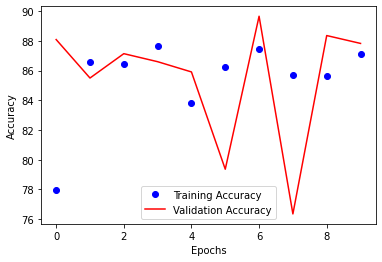

In [18]:
# visualize training metrics
# your code here

import matplotlib.pyplot as plt
%matplotlib inline

epochs_list = range(len(train_acc))

plt.plot(epochs_list, train_acc, 'bo', label='Training Accuracy')
plt.plot(epochs_list, val_acc, 'r', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Question

Do you think overfitting is happening? If yes, what can you do? Please make necessary changes to the supervised autoencoder network structure.

### 4.3. Visualize the low-dimensional features

In [19]:
# visualize the features
# your code here

sae.eval()
code_vector_list = None
label_list = []
for i, (data, labels) in enumerate(test_loader):
    data = Variable(data).cuda()
    code_vector = sae.encoder(data.view(-1, 28*28))

    if i == 0:
        code_vector_list = code_vector
        label_list = labels
    else:
        code_vector_list = torch.cat((code_vector_list, code_vector), 0)
        label_list = torch.cat((label_list, labels), 0)

code_vector_list = code_vector_list.data.cpu().numpy()[:1000]
label_list = label_list.cpu().numpy()[:1000]

No handles with labels found to put in legend.


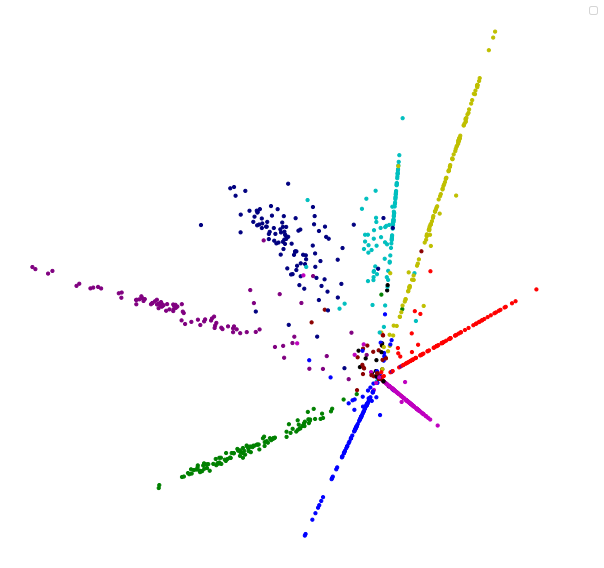

In [20]:
colors = np.array(['r', 'g', 'b', 'm', 'c', 'k', 'y', 'purple', 'darkred', 'navy'])
colors_test = colors[label_list]

fig = plt.figure(figsize=(8, 8))
plt.scatter(code_vector_list[:, 0], code_vector_list[:, 1], s=10, c=colors_test, edgecolors=colors_test)
plt.axis('off')
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
fname = 'sae_code.pdf'
plt.savefig(fname)

### 4.4. Are the learned low-dim features discriminative?

To find the answer, lets train a classifier on the training set (the extracted 2-dim features) and evaluation on the validation and test set.


In [21]:
# build a classifier which takes the 2D features from supervised autoencoder as input
# your code here

classifier = nn.Sequential(
                nn.Linear(2, 32),
                nn.ReLU(True),
                nn.Linear(32, 64),
                nn.ReLU(True),
                nn.Linear(64, 10)).cuda()

In [22]:
classifier_criterion = nn.CrossEntropyLoss()
classifier_optimizer = torch.optim.Adam(
    classifier.parameters(), lr=learning_rate)

In [23]:
for epoch in range(epochs):
    classifier.train()
    running_loss = 0.0
    running_acc = 0
    for img, y in train_loader:
        img = img.view(img.size(0), -1)
        img, y = img.cuda(), y.cuda()
        # ===================forward=====================
        code_vector = sae.encoder(img)
        y_hat = classifier(code_vector)
        loss = classifier_criterion(y_hat, y)
        # ===================backward====================
        classifier_optimizer.zero_grad()
        loss.backward()
        classifier_optimizer.step()

        # print statistics
        running_loss += loss.item() * img.size(0)
        out = torch.argmax(y_hat.detach(),dim=1)
        assert out.shape==y.shape
        running_acc += (y==out).sum().item()
    print(f"Train loss {epoch+1}: {running_loss/len(train_dataset)},Train Acc:{running_acc*100/len(train_dataset)}%")

    correct = 0
    classifier.eval()
    with torch.no_grad():
        for img, y in val_loader:
            img = img.view(img.size(0), -1)
            img, y = img.cuda(), y.cuda()
            code_vector = sae.encoder(img)
            y_hat = classifier(code_vector)
            y_hat = torch.argmax(y_hat, dim=1)
            acc = (y_hat==y).sum().item()
            correct += acc
    print(f"Val accuracy:{correct*100/len(val_dataset)}%")

Train loss 1: 0.4826481985855103,Train Acc:87.876%
Val accuracy:88.61%
Train loss 2: 0.41648604333639144,Train Acc:88.538%
Val accuracy:88.45%
Train loss 3: 0.413257993991375,Train Acc:88.556%
Val accuracy:88.73%
Train loss 4: 0.41211842387199404,Train Acc:88.502%
Val accuracy:88.26%
Train loss 5: 0.41024949073791506,Train Acc:88.68%
Val accuracy:88.71%
Train loss 6: 0.40827395336389544,Train Acc:88.61%
Val accuracy:88.67%
Train loss 7: 0.4157996887898445,Train Acc:88.366%
Val accuracy:88.92%
Train loss 8: 0.40658603645920754,Train Acc:88.586%
Val accuracy:88.45%
Train loss 9: 0.40407551672458647,Train Acc:88.726%
Val accuracy:88.63%
Train loss 10: 0.4054729336643219,Train Acc:88.612%
Val accuracy:88.11%


#### Remark:

The validation accuracy must be above 85%. It means the low-dim features learned by the supervised autoencoder are very effective.

In [24]:
# evaluate your model on the never-seen-before test data
# your code here

correct = 0
classifier.eval()
with torch.no_grad():
    for img, y in test_loader:
            img = img.view(img.size(0), -1)
            img, y = img.cuda(), y.cuda()
            code_vector = sae.encoder(img)
            y_hat = classifier(code_vector)
            y_hat = torch.argmax(y_hat, dim=1)
            acc = (y_hat==y).sum().item()
            correct += acc
    print(f"Test accuracy:{correct*100/len(val_dataset)}%")

Test accuracy:89.08%
